In [2]:
import pandas as pd
from scipy import stats
import numpy as np
from google.colab import drive
import plotly.express as px

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/My Drive/uber.csv')

df = data.copy()

# see the complete dataframe
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

In [4]:
#import dependencies

import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import metrics
import math
from statsmodels.tools.eval_measures import rmse

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

In [5]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [7]:
df.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [8]:
#drop unnecessary columns
df = df.drop(['Unnamed: 0', 'key'], axis= 1)

In [9]:
df.shape

(200000, 7)

In [10]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [11]:
df.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [12]:
#changing pickup date and time from object to datetime
df.pickup_datetime = pd.to_datetime(df.pickup_datetime, errors='coerce')
# For datetime64[ns] types, NaT represents missing values.

In [13]:
df.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [14]:
# we will extract time feature from the 'pickup_datetime'
# we will add a variable which measures the distance between pickup and drop

df= df.assign(hour = df.pickup_datetime.dt.hour,
             day= df.pickup_datetime.dt.day,
             month = df.pickup_datetime.dt.month,
             year = df.pickup_datetime.dt.year,
             dayofweek = df.pickup_datetime.dt.dayofweek)

In [15]:
#using heversine formula to calc distance between 2 points
from math import *

In [16]:
# function to calculate the travel distance from the longitudes and latitudes
def distance_transform(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []

    for pos in range(len(longitude1)):
        long1,lati1,long2,lati2 = map(radians,[longitude1[pos],latitude1[pos],longitude2[pos],latitude2[pos]])
        dist_long = long2 - long1
        dist_lati = lati2 - lati1
        a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
        c = 2 * asin(sqrt(a))*6371
        travel_dist.append(c)

    return travel_dist

In [17]:
df['dist_travel_km'] = distance_transform(df['pickup_longitude'].to_numpy(),
                                                df['pickup_latitude'].to_numpy(),
                                                df['dropoff_longitude'].to_numpy(),
                                                df['dropoff_latitude'].to_numpy()
                                              )

In [18]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,2015,3,1.683323
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2009,4,2.457590
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,2009,0,5.036377
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6,2009,4,1.661683
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8,2014,3,4.475450


In [19]:
# now we can drop the pickup_datetime variable beacause now we got the distance
#and it becomes redundant now.

df = df.drop('pickup_datetime',axis=1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        200000 non-null  float64
 1   pickup_longitude   200000 non-null  float64
 2   pickup_latitude    200000 non-null  float64
 3   dropoff_longitude  199999 non-null  float64
 4   dropoff_latitude   199999 non-null  float64
 5   passenger_count    200000 non-null  int64  
 6   hour               200000 non-null  int64  
 7   day                200000 non-null  int64  
 8   month              200000 non-null  int64  
 9   year               200000 non-null  int64  
 10  dayofweek          200000 non-null  int64  
 11  dist_travel_km     199999 non-null  float64
dtypes: float64(6), int64(6)
memory usage: 18.3 MB


In [21]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fare_amount,200000.0,11.359955,9.901776,-52.000000,6.000000,8.500000,12.500000,499.000000
pickup_longitude,200000.0,-72.527638,11.437787,-1340.648410,-73.992065,-73.981823,-73.967154,57.418457
pickup_latitude,200000.0,39.935885,7.720539,-74.015515,40.734796,40.752592,40.767158,1644.421482
dropoff_longitude,199999.0,-72.525292,13.117408,-3356.666300,-73.991407,-73.980093,-73.963658,1153.572603
dropoff_latitude,199999.0,39.923890,6.794829,-881.985513,40.733823,40.753042,40.768001,872.697628
passenger_count,200000.0,1.684535,1.385997,0.000000,1.000000,1.000000,2.000000,208.000000
hour,200000.0,13.491335,6.515531,0.000000,9.000000,14.000000,19.000000,23.000000
day,200000.0,15.704670,8.687409,1.000000,8.000000,16.000000,23.000000,31.000000
month,200000.0,6.281795,3.438925,1.000000,3.000000,6.000000,9.000000,12.000000
year,200000.0,2011.742440,1.856397,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000


In [22]:
df.columns[df.dtypes == 'object']

Index([], dtype='object')

Discover and remove Outliers


In [23]:
#outliers in this study:
#Amount < -52
#Trips with travel distance less than or equal to 0, and more than 130Kms
#Trips where 90< latitude <-90, 180 < longitude < -180

In [24]:
df.fare_amount.min()

-52.0

<Axes: >

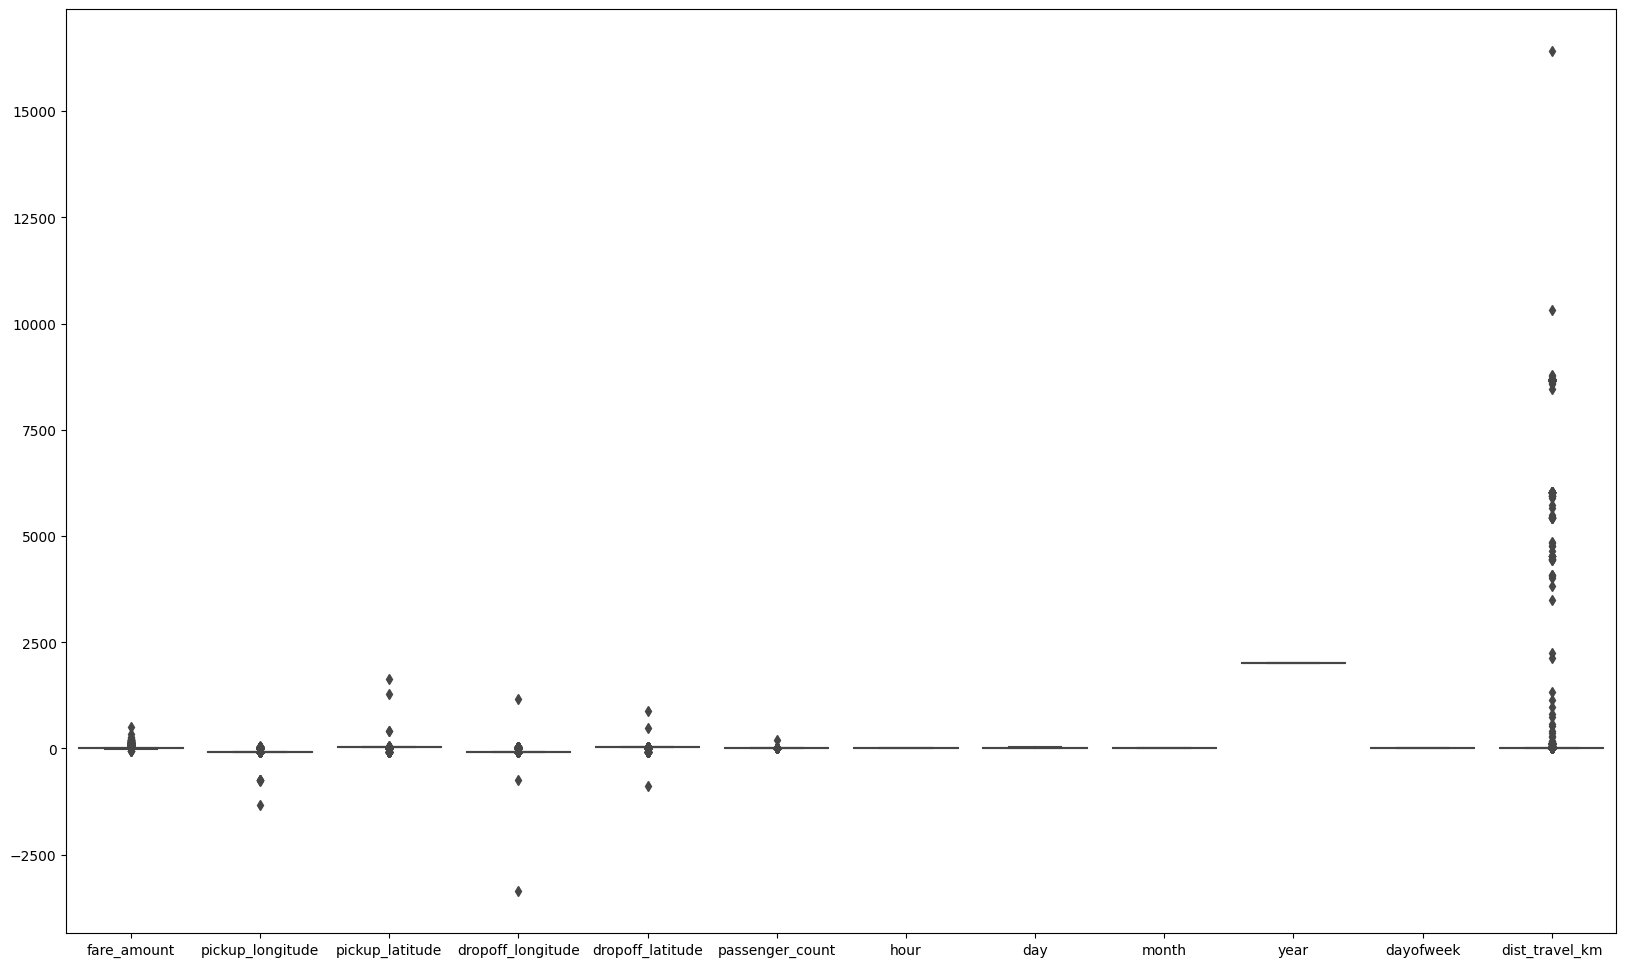

In [25]:
plt.figure(figsize=(20,12))
sns.boxplot(data= df)

In [26]:
#fill missing values as medians of the columns

medianFiller = lambda x : x.fillna(x.median())
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_columns] = df[numeric_columns].apply(medianFiller, axis = 0)

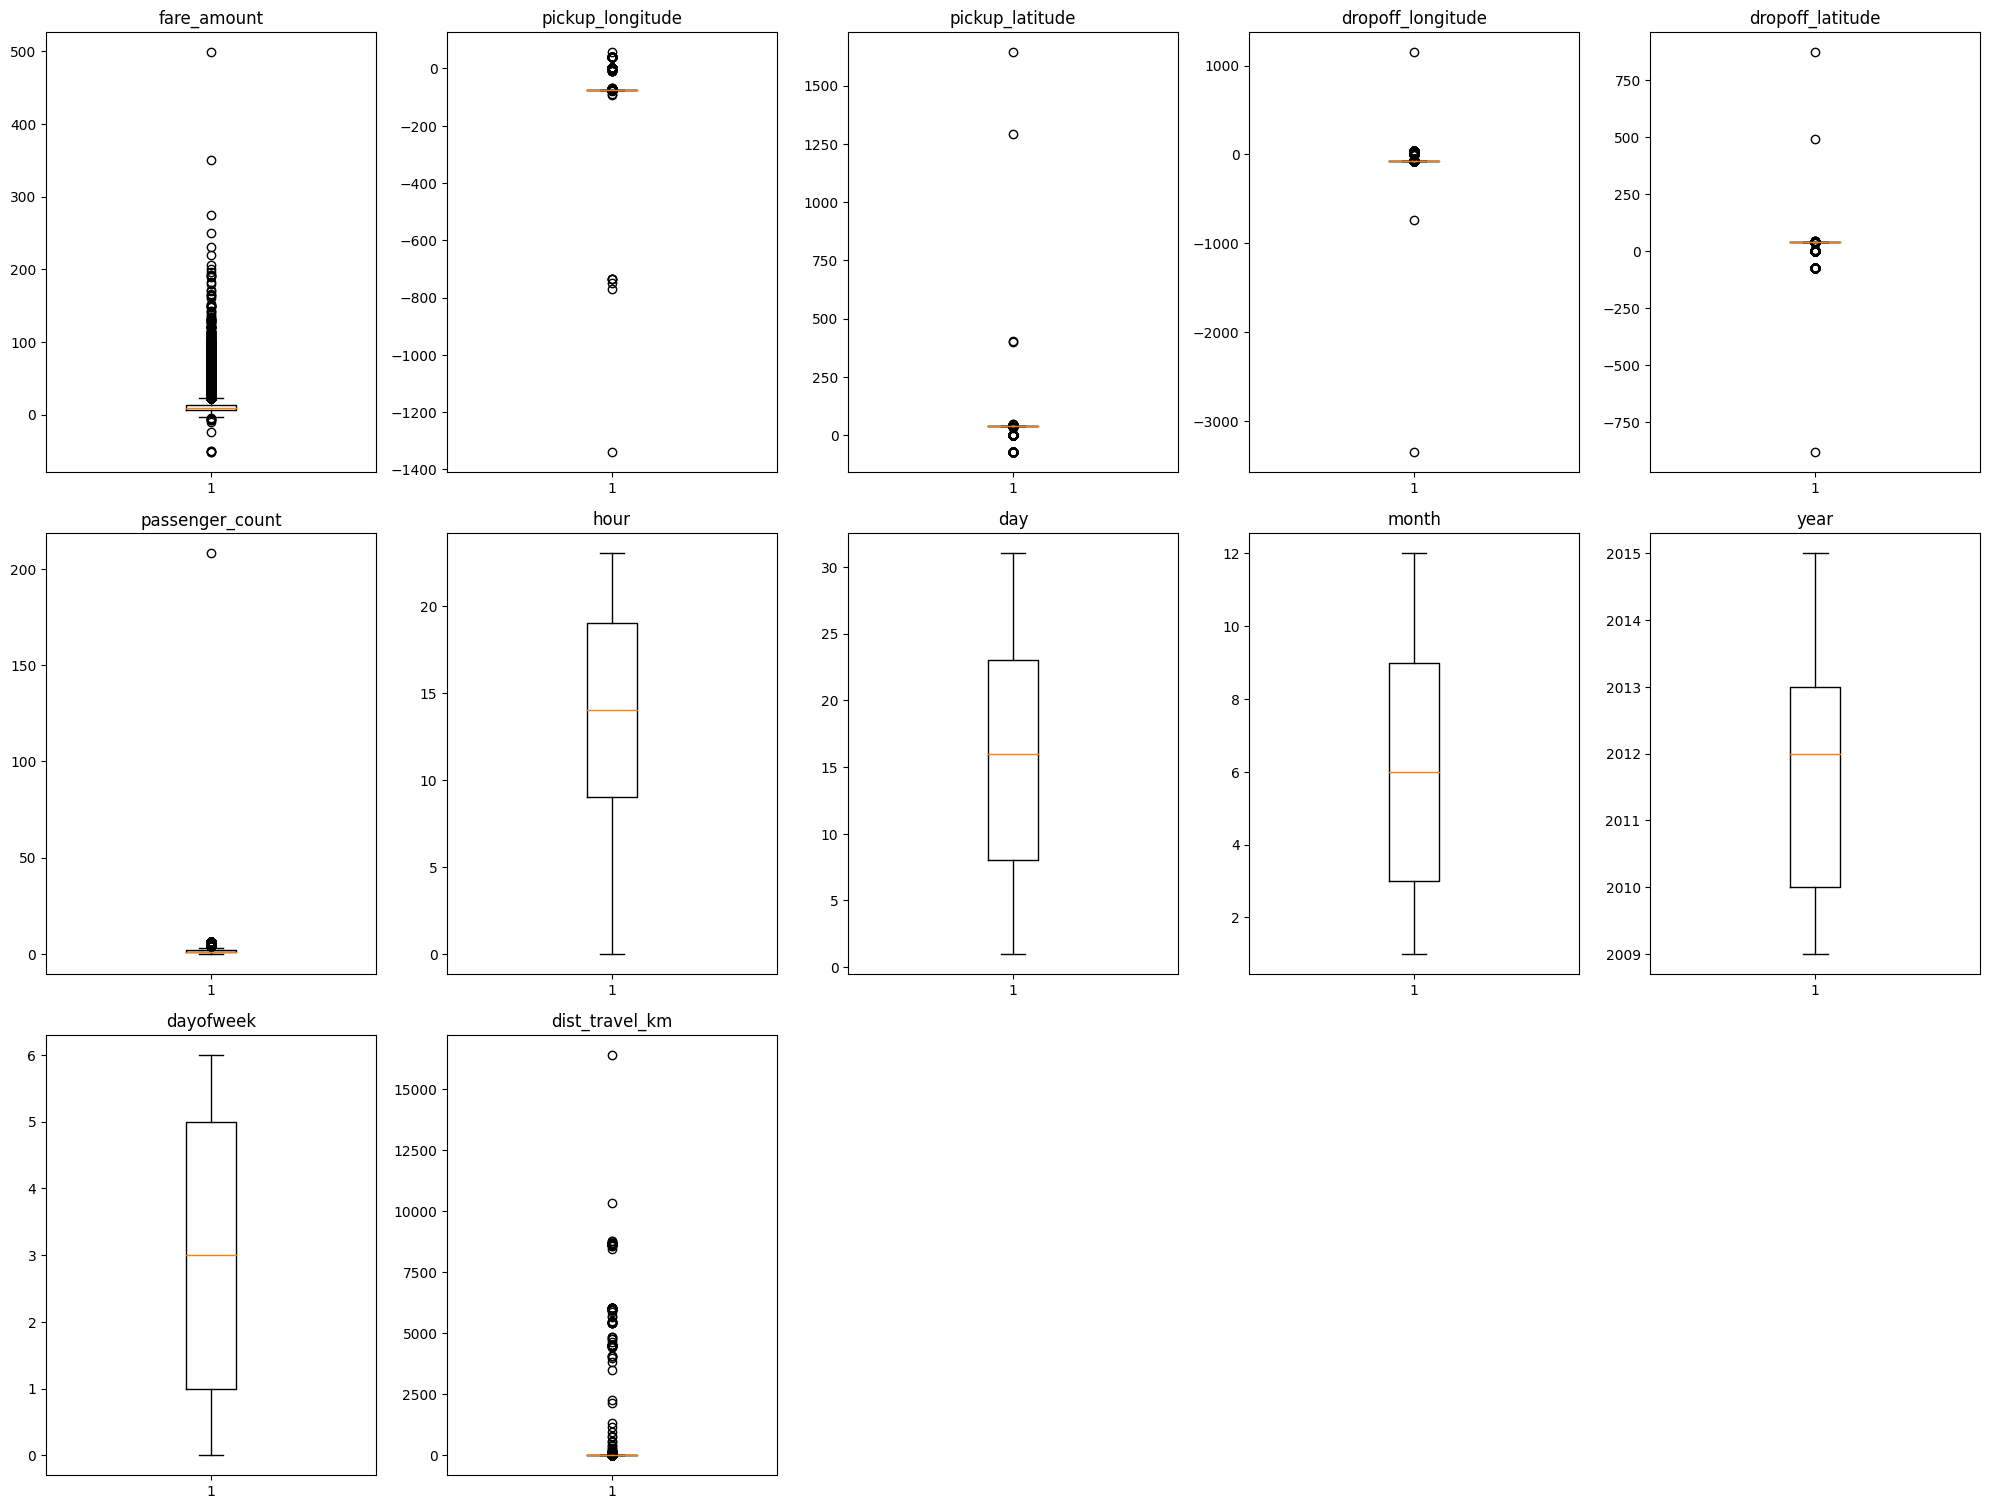

In [27]:
# outliers detection using boxplot
plt.figure(figsize =(20, 30))

for i , variable in enumerate(numeric_columns):
    plt.subplot(6 , 5, i +1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

In [28]:
#only keep positive fare amounts
df = df.loc[(df.fare_amount >= 0)]

In [29]:
df.shape

(199983, 12)

In [30]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,2015,3,1.683323
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2009,4,2.457590
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,2009,0,5.036377
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6,2009,4,1.661683
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8,2014,3,4.475450


In [31]:
def remove_outlier(df1 , col):
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1-1.5*IQR
    upper_whisker = Q3+1.5*IQR
    df[col] = np.clip(df1[col] , lower_whisker , upper_whisker)
    return df1

def treat_outliers_all(df1 , col_list):
    for c in col_list:
        df1 = remove_outlier(df , c)
    return df1

In [32]:
df = treat_outliers_all(df , df.iloc[: , 0::])

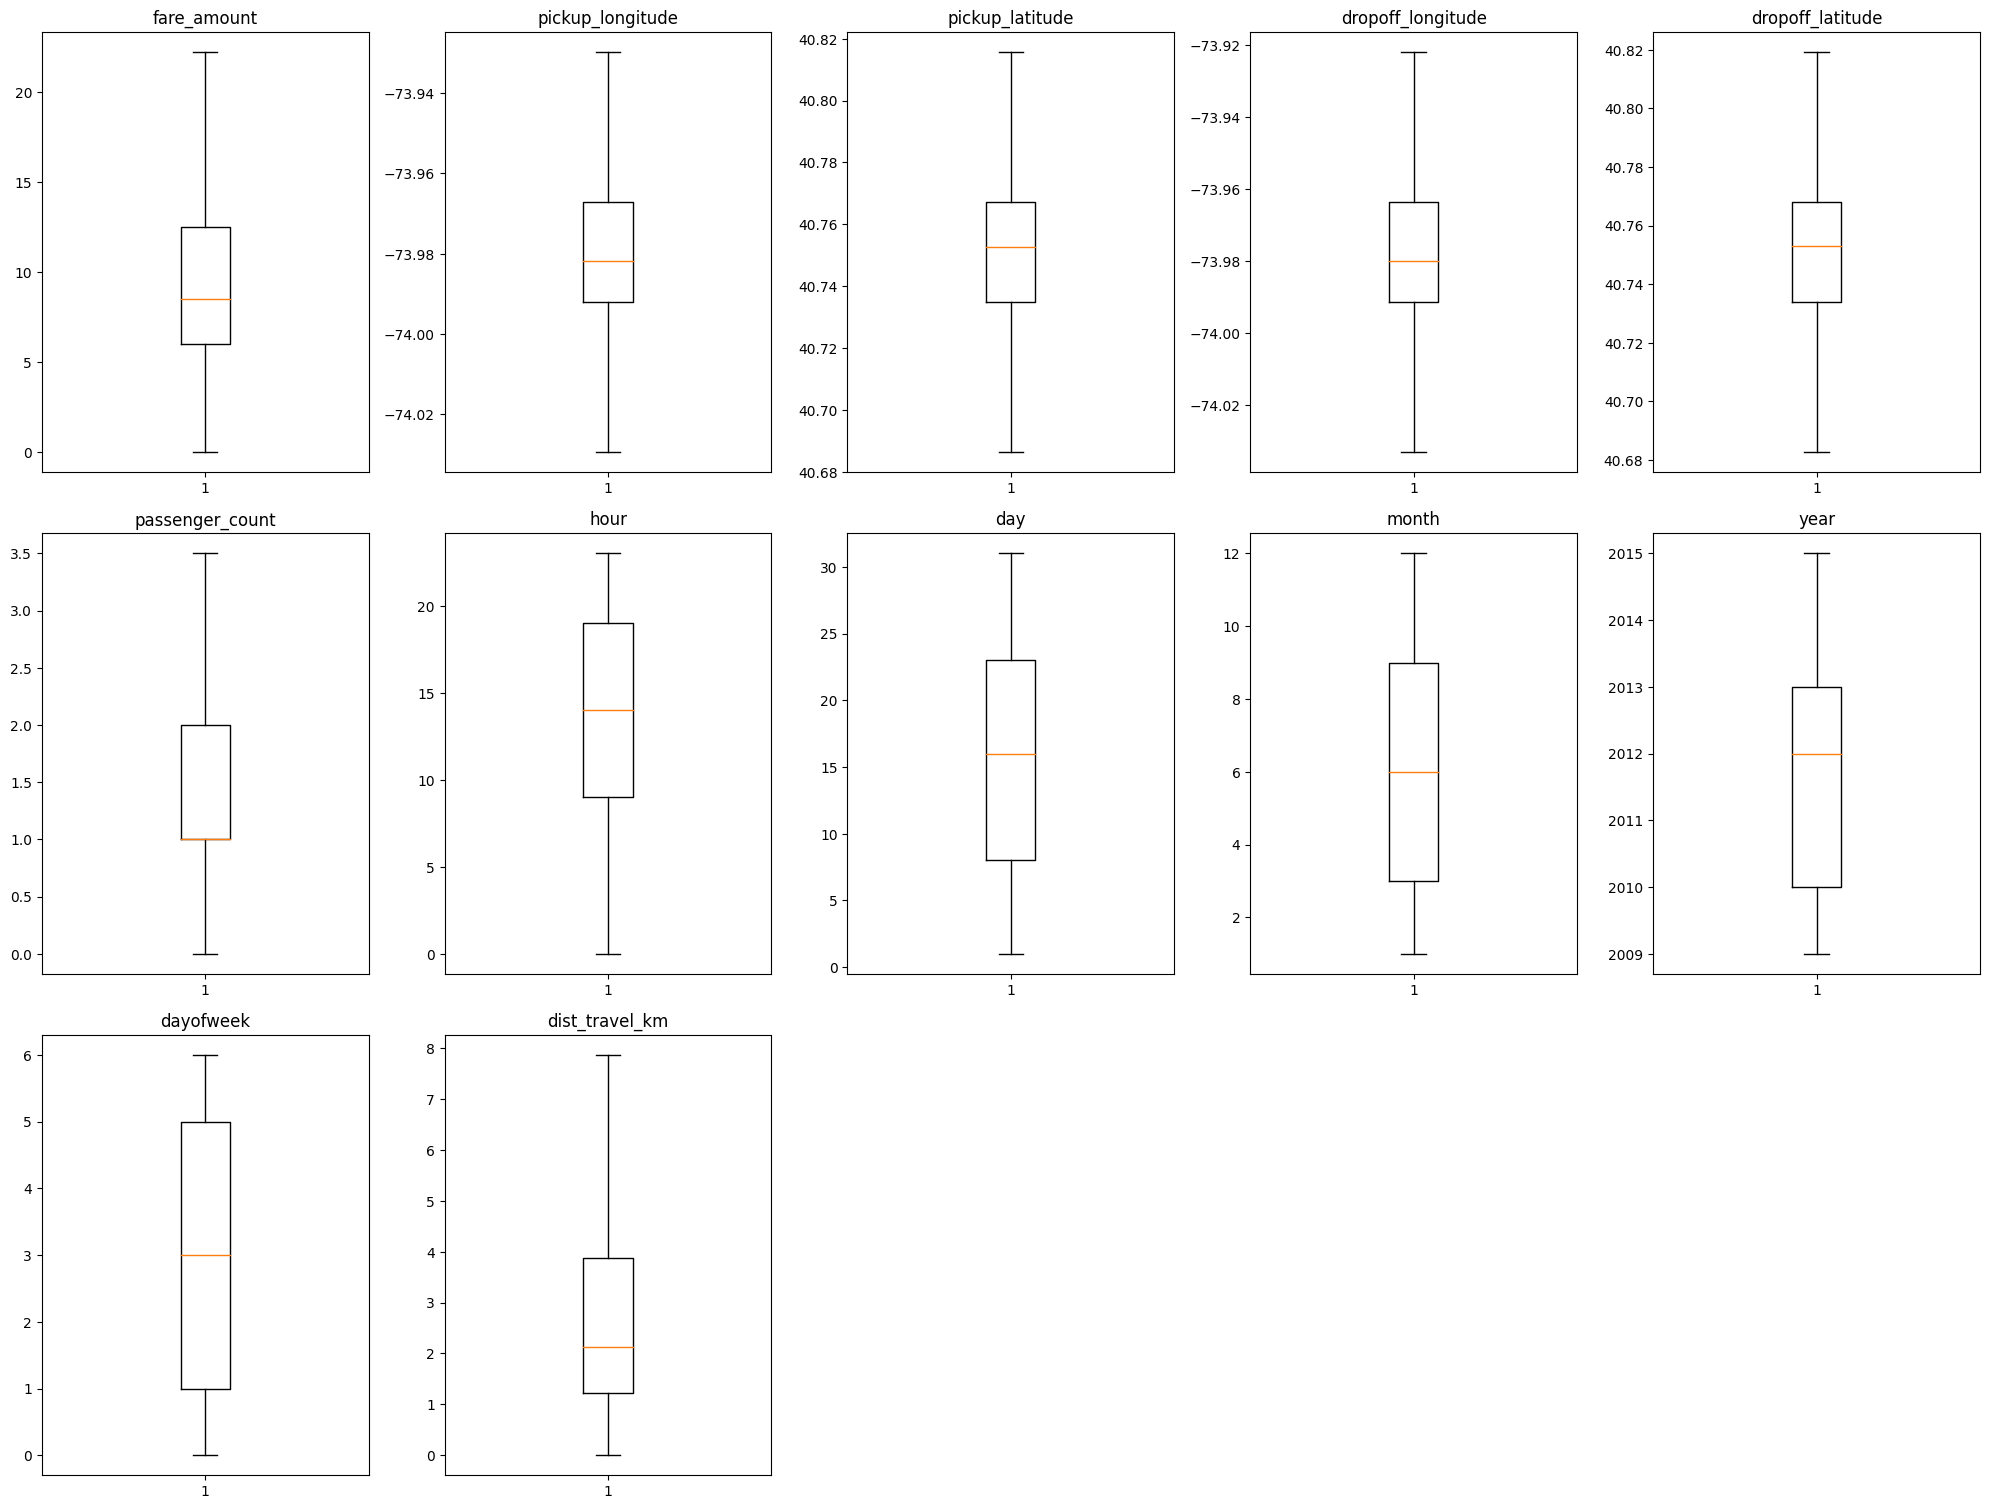

In [33]:
plt.figure(figsize=(20,30))
for i , variable in enumerate(df.iloc[: , 0::]):
    plt.subplot(6,5,i+1)
    plt.boxplot(df[variable] , whis = 1.5)
    plt.tight_layout()
    plt.title(variable)
plt.show()

In [34]:
#We will only keep the observation where travel distance is less than or equal to 130
df= df.loc[(df.dist_travel_km >= 1) | (df.dist_travel_km <= 130)]

In [35]:
incorrect_coordinates = df.loc[(df.pickup_latitude > 90) |(df.pickup_latitude < -90) |
                                   (df.dropoff_latitude > 90) |(df.dropoff_latitude < -90) |
                                   (df.pickup_longitude > 180) |(df.pickup_longitude < -180) |
                                   (df.dropoff_longitude > 90) |(df.dropoff_longitude < -90)
                                    ]

In [36]:
df.drop(incorrect_coordinates, inplace = True, errors = 'ignore')

In [37]:
df.shape

(199983, 12)

Cheacking and treating remaining missing values


In [38]:
# sort the variables on the basis of total null values in the variable
# 'isnull().sum()' returns the number of missing values in each variable
# 'ascending = False' sorts values in the descending order
# the variable with highest number of missing values will appear first
Total = df.isnull().sum().sort_values(ascending = False)

# calculate the percentage of missing values
# 'ascending = False' sorts values in the descending order
# the variable with highest percentage of missing values will appear first
Percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending = False)

# concat the 'Total' and 'Percent' columns using 'concat' function
# 'keys' is the list of column names
# 'axis = 1' concats along the columns
missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])

# add the column containing data type of each variable
missing_data['Type'] = df[missing_data.index].dtypes
missing_data

#there are no remaining missing values

,Total,Percentage of Missing Values,Type
fare_amount,0,0.0,float64
pickup_longitude,0,0.0,float64
pickup_latitude,0,0.0,float64
dropoff_longitude,0,0.0,float64
dropoff_latitude,0,0.0,float64
passenger_count,0,0.0,float64
hour,0,0.0,int64
day,0,0.0,int64
month,0,0.0,int64
year,0,0.0,int64


In [39]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1.0,19,7,5,2015,3,1.683323
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1.0,20,17,7,2009,4,2.457590
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1.0,21,24,8,2009,0,5.036377
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3.0,8,26,6,2009,4,1.661683
4,16.0,-73.929788,40.744085,-73.973082,40.761247,3.5,17,28,8,2014,3,4.475450


Standardization

In [40]:
from sklearn.preprocessing import StandardScaler
# Select numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the numeric columns
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [41]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
0,-0.474771,-1.048684,-0.461521,-1.019219,-0.939800,-0.586673,0.845484,-1.002017,-0.372805,1.754899,-0.024892,-0.526548
1,-0.437999,-0.782355,-0.856266,-0.809351,0.006056,-0.586673,0.998965,0.149066,0.208772,-1.477320,0.488728,-0.178356
2,0.518057,-1.303515,-0.367352,0.595605,0.784918,-0.586673,1.152446,0.954825,0.499560,-1.477320,-1.565752,0.981337
3,-0.879256,0.106611,1.584172,0.475368,1.856176,1.694619,-0.842806,1.185042,-0.082016,-1.477320,0.488728,-0.536279
4,1.088014,2.366037,-0.238157,0.135940,0.387148,2.264942,0.538522,1.415258,0.499560,1.216196,-0.024892,0.729085


Split the dataset for Modelling

In [42]:
# split data into train data and test data
# what proportion of data should be included in test data is passed using 'test_size'
# set 'random_state' to get the same data each time the code is executed

In [43]:
# select only the target variable 'amount' and store it in dataframe 'y'
y = pd.DataFrame(df['fare_amount'])

In [44]:
# use 'drop()' to remove the variable 'amount' from df_taxi
# 'axis = 1' drops the corresponding column(s)
x = df.drop('fare_amount',axis = 1)

In [45]:
x.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
0,-1.048684,-0.461521,-1.019219,-0.939800,-0.586673,0.845484,-1.002017,-0.372805,1.754899,-0.024892,-0.526548
1,-0.782355,-0.856266,-0.809351,0.006056,-0.586673,0.998965,0.149066,0.208772,-1.477320,0.488728,-0.178356
2,-1.303515,-0.367352,0.595605,0.784918,-0.586673,1.152446,0.954825,0.499560,-1.477320,-1.565752,0.981337
3,0.106611,1.584172,0.475368,1.856176,1.694619,-0.842806,1.185042,-0.082016,-1.477320,0.488728,-0.536279
4,2.366037,-0.238157,0.135940,0.387148,2.264942,0.538522,1.415258,0.499560,1.216196,-0.024892,0.729085


In [58]:
# split data into train subset and test subset for predictor and target variables
# 'test_size' returns the proportion of data to be included in the test set
# set 'random_state' to generate the same dataset each time you run the code
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

# check the dimensions of the train & test subset for
# print dimension of predictors train set
print("The shape of X_train is:",X_train.shape)

# print dimension of predictors test set
print("The shape of X_test is:",X_test.shape)

# print dimension of target train set
print("The shape of y_train is:",y_train.shape)

# print dimension of target test set
print("The shape of y_test is:",y_test.shape)

The shape of X_train is: (159986, 11)
The shape of X_test is: (39997, 11)
The shape of y_train is: (159986, 1)
The shape of y_test is: (39997, 1)


In [60]:
X_train.dtypes

pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
hour                 float64
day                  float64
month                float64
year                 float64
dayofweek            float64
dist_travel_km       float64
dtype: object

KNN from scratch

In [61]:
#helper function to figure out the most commonly occuring element in a given group at numerous times in this algorithm
def most_common(lst):
    '''Returns the most common element in a list'''
    return max(set(lst), key=lst.count)


In [67]:
#calculate the distance between a point and every point in a dataset
def euclidean(x, X):
    return np.sqrt(np.sum((X - x)**2, axis=1))

In [63]:
pip install scikit-learn

In [64]:
import sklearn
import sklearn.metrics
from sklearn.metrics import accuracy_score

In [65]:
import numpy as np
import pandas as pd

# Function to check data type of each dataset
def check_data_types(X_train, X_test, y_train, y_test):
    print("Type of X_train:", type(X_train))
    print("Type of each element in X_train:", type(X_train[0]) if len(X_train) > 0 else 'Empty')
    print("Type of X_test:", type(X_test))
    print("Type of each element in X_test:", type(X_test[0]) if len(X_test) > 0 else 'Empty')
    print("Type of y_train:", type(y_train))
    print("Type of each element in y_train:", type(y_train[0]) if len(y_train) > 0 else 'Empty')
    print("Type of y_test:", type(y_test))
    print("Type of each element in y_test:", type(y_test[0]) if len(y_test) > 0 else 'Empty')

# Assuming X_train, X_test, y_train, y_test are already defined
# For example purposes, let's create dummy data
X_train = np.random.rand(100, 5)  # 100 samples, 5 features each
y_train = np.random.randint(0, 2, 100)  # 100 labels (binary classification)
X_test = np.random.rand(50, 5)   # 50 samples, 5 features each
y_test = np.random.randint(0, 2, 50)   # 50 labels

# Call the function with your data
check_data_types(X_train, X_test, y_train, y_test)


Type of X_train: <class 'numpy.ndarray'>
Type of each element in X_train: <class 'numpy.ndarray'>
Type of X_test: <class 'numpy.ndarray'>
Type of each element in X_test: <class 'numpy.ndarray'>
Type of y_train: <class 'numpy.ndarray'>
Type of each element in y_train: <class 'numpy.int64'>
Type of y_test: <class 'numpy.ndarray'>
Type of each element in y_test: <class 'numpy.int64'>


In [70]:
#For each datapoint the following steps are performed:
#Distances to every point in the training dataset is calculated
#The training dataset classes are sorted by distance to the data point
#The first k classes are kept and stored in the neighbors list Now we simply map the list of nearest neighbors to our most_common function, returning a list of predictions for each point passed in X_test.

class KNeighborsClassifier():
    def __init__(self, k=5, dist_metric=euclidean):
        self.k = k
        self.dist_metric = dist_metric
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    def predict(self, X_test):
        neighbors = []
        for x in X_test:
            # Ensure x is a 1D array representing a single data point
            x = np.array(x).flatten()
            distances = self.dist_metric(x, self.X_train)
            y_sorted = [y for _, y in sorted(zip(distances, self.y_train))]
            neighbors.append(y_sorted[:self.k])
        return list(map(most_common, neighbors))
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = sum(y_pred == y_test) / len(y_test)
        return accuracy




In [71]:
accuracies = []
ks = range(1, 30)
for k in ks:
    knn = KNeighborsClassifier(k=k)
    knn.fit(X_train, y_train)
    accuracy = knn.evaluate(X_test, y_test)
    accuracies.append(accuracy)

In [72]:
print(accuracies)

[0.58, 0.56, 0.58, 0.56, 0.6, 0.54, 0.56, 0.58, 0.6, 0.54, 0.62, 0.54, 0.56, 0.54, 0.52, 0.56, 0.54, 0.5, 0.44, 0.4, 0.44, 0.44, 0.42, 0.44, 0.48, 0.46, 0.54, 0.52, 0.46]


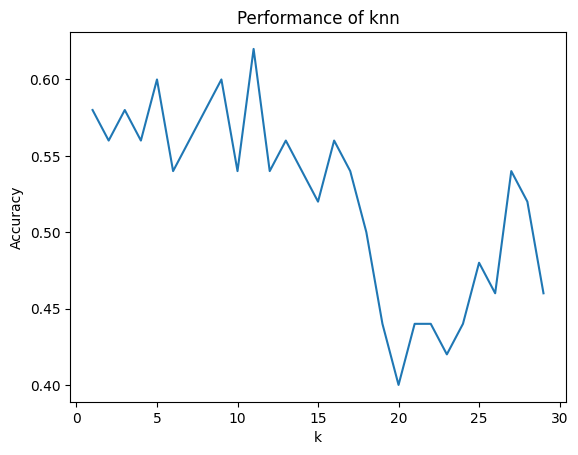

In [73]:
# Visualize accuracy vs. k
fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="k",
       ylabel="Accuracy",
       title="Performance of knn")
plt.show()

SVM

In [75]:
pip install scikit-learn matplotlib

In [76]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
svm_model = SVC(kernel='linear')  # You can change the kernel based on your needs
svm_model.fit(X_train, y_train)


SVC(kernel='linear')

In [78]:
y_pred = svm_model.predict(X_test)

In [79]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.48      1.00      0.65        24

    accuracy                           0.48        50
   macro avg       0.24      0.50      0.32        50
weighted avg       0.23      0.48      0.31        50



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


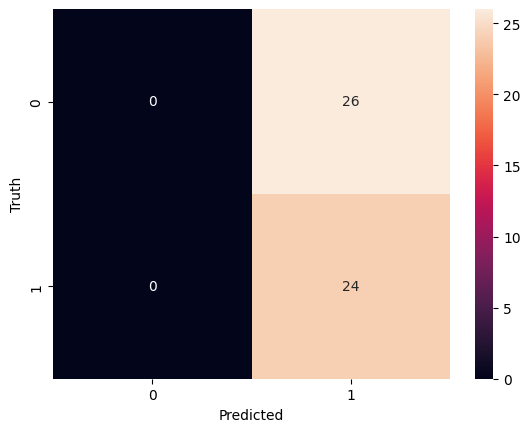

In [81]:
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

Decision Tree

In [83]:
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [86]:
# instantiate the 'DecisionTreeRegressor' object using 'squared_error' criterion
decision_tree = DecisionTreeRegressor(criterion='squared_error', random_state=10)

# fit the model using fit() on train data
decision_tree_model = decision_tree.fit(X_train, y_train)

In [87]:
y_pred_DT=decision_tree_model.predict(X_test)

In [88]:
y_pred_DT

array([0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.])

In [89]:
y_test

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1])

In [91]:
r_squared_DT=decision_tree_model.score(X_test,y_test)
# Number of observation or sample size
n = 159999

# No of independent variables
p = 11

#Compute Adj-R-Squared
Adj_r_squared_DT = 1 - (1-r_squared_DT)*(n-1)/(n-p-1)
Adj_r_squared_DT

-0.7629417165785743

In [94]:
import pandas as pd

# Check if 'result_tabulation' is already defined, if not, create an empty DataFrame
if 'result_tabulation' not in locals():
    result_tabulation = pd.DataFrame()

# Compile the required information
linreg_full_metrics = pd.Series({'Model': "Decision Tree Model",
                                 'R-Squared': r_squared_DT,
                                 'Adj. R-Squared': Adj_r_squared_DT})

# Append our result table using append()
result_tabulation = result_tabulation.append(linreg_full_metrics, ignore_index=True)

# Print the result table
print(result_tabulation)


                 Model  R-Squared  Adj. R-Squared
0  Decision Tree Model  -0.762821       -0.762942


<ipython-input-94-e23593bf39a2>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_tabulation = result_tabulation.append(linreg_full_metrics, ignore_index=True)


In [95]:
# compile the required information
linreg_full_metrics = pd.Series({'Model': "Decision Tree Model ",
                     'R-Squared': r_squared_DT,
                     'Adj. R-Squared': Adj_r_squared_DT
                   })

# append our result table using append()
# ignore_index=True: does not use the index labels
# python can only append a Series if ignore_index=True or if the Series has a name
result_tabulation = result_tabulation.append(linreg_full_metrics, ignore_index = True)

# print the result table
result_tabulation

<ipython-input-95-12a150665616>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_tabulation = result_tabulation.append(linreg_full_metrics, ignore_index = True)


,Model,R-Squared,Adj. R-Squared
0,Decision Tree Model,-0.762821,-0.762942
1,Decision Tree Model,-0.762821,-0.762942


Random Forest


In [96]:
# import library for random forest regressor
from sklearn.ensemble import RandomForestRegressor

In [98]:
#intantiate the regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=10)

# fit the regressor with training dataset
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=10)

In [99]:
# predict the values on test dataset using predict()
y_pred_RF = rf_reg.predict(X_test)

In [100]:
y_pred_RF

array([0.8 , 0.8 , 0.53, 0.59, 0.48, 0.49, 0.68, 0.94, 0.74, 0.38, 0.75,
       0.64, 0.65, 0.75, 0.58, 0.52, 0.35, 0.6 , 0.65, 0.65, 0.64, 0.63,
       0.47, 0.6 , 0.71, 0.19, 0.79, 0.54, 0.55, 0.28, 0.88, 0.47, 0.47,
       0.49, 0.19, 0.77, 0.42, 0.53, 0.69, 0.47, 0.18, 0.58, 0.65, 0.31,
       0.3 , 0.57, 0.22, 0.81, 0.3 , 0.81])

In [102]:
from sklearn.metrics import mean_squared_error
from math import sqrt
r_squared_RF = rf_reg.score(X_test,y_test)
# Number of observation or sample size
n = 159999

# No of independent variables
p = 11

#Compute Adj-R-Squared
Adj_r_squared_RF = 1 - (1-r_squared_RF)*(n-1)/(n-p-1)
Adj_r_squared_RF
# Compute RMSE
rmse_RF = sqrt(mean_squared_error(y_test, y_pred_RF))

In [103]:
# Calculate MAE
rf_reg_MAE = metrics.mean_absolute_error(y_test, y_pred_RF)
print('Mean Absolute Error (MAE):', rf_reg_MAE)

# Calculate MSE
rf_reg_MSE = metrics.mean_squared_error(y_test, y_pred_RF)
print('Mean Squared Error (MSE):', rf_reg_MSE)

# Calculate RMSE
rf_reg_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF))
print('Root Mean Squared Error (RMSE):', rf_reg_RMSE)

Mean Absolute Error (MAE): 0.4668
Mean Squared Error (MSE): 0.255712
Root Mean Squared Error (RMSE): 0.5056797405473151


In [104]:
# compile the required information
linreg_full_metrics = pd.Series({'Model': "Random Forest ",
                     'RMSE':rf_reg_RMSE,
                     'R-Squared': r_squared_RF,
                     'Adj. R-Squared': Adj_r_squared_RF
                   })

# append our result table using append()
# ignore_index=True: does not use the index labels
# python can only append a Series if ignore_index=True or if the Series has a name
result_tabulation = result_tabulation.append(linreg_full_metrics, ignore_index = True)

# print the result table
result_tabulation

<ipython-input-104-1ee2dc760e08>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_tabulation = result_tabulation.append(linreg_full_metrics, ignore_index = True)


,Model,R-Squared,Adj. R-Squared,RMSE
0,Decision Tree Model,-0.762821,-0.762942,NaN
1,Decision Tree Model,-0.762821,-0.762942,NaN
2,Random Forest,-0.024487,-0.024558,0.50568


Gradient Boosting

In [105]:
from sklearn.ensemble import GradientBoostingClassifier


In [106]:
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)


In [107]:
model.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

In [108]:
y_pred = model.predict(X_test)


In [110]:
from sklearn.metrics import accuracy_score, mean_squared_error

# For classification
accuracy = accuracy_score(y_test, y_pred)


In [112]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df.head(10))  # Print first 10 rows

   Actual  Predicted
0       0          1
1       1          1
2       0          0
3       1          1
4       1          1
5       0          1
6       1          1
7       0          1
8       1          1
9       0          0


Hyper Parameter Tuning

In [119]:
hyperparameters = {
    'n_neighbors': [3, 5, 7, 9],
    'p': [1, 2]  # 1 is Manhattan distance, 2 is Euclidean distance
}

# Define the evaluation metric
def evaluate_model(model, X_train, y_train, X_val, y_val, parameters):
    model.train(X_train, y_train)
    predictions = model.predict(X_val)
    # Here you would calculate your evaluation metric (e.g., accuracy)
    metric = accuracy_score(y_val, predictions)
    return metric

# Define a function to perform grid search
def grid_search(model, hyperparameters, X_train, y_train, X_val, y_val):
    best_score = 0
    best_params = {}

    # Iterate over all combinations of hyperparameters
    for n_neighbors in hyperparameters['n_neighbors']:
        for p in hyperparameters['p']:
            # Evaluate the current combination
            params = {'n_neighbors': n_neighbors, 'p': p}
            score = evaluate_model(model, X_train, y_train, X_val, y_val, params)

            # If the current combination is better than the previous best, update the best
            if score > best_score:
                best_score = score
                best_params = params

    return best_params, best_score

best_params, best_score = grid_search(KNeighborsClassifier(), hyperparameters, X_train, y_train, X_test, y_test)


AttributeError: ignored